# Advanced Econometrics Exam - 2016

**Opgaver**
1. ARMA og ARIMA modeller [30%]
2. Kointegration og fejlkorrektion [20%]
3. Volalitetsmodeller [25%]
4. Vektorautoregressive modeller [25%]

Data findes i en række CSV filer på moodle: 
- volatilitet.csv 
- VektorAutoregressiv.csv
- renter.csv
- bnpdef.csv

In [55]:
library(tidyverse) # Readr, ggplot, dplyr, ...
library(gridExtra) # Arrangning ggplots
library(readxl)    # Loading excel
library(repr)      # Resizing the plots in jupyter
library(rugarch)   # For ARCH and GARCH models
library(dynlm)     # Lagged linear models
library(urca)      # Dick Fuller test
library(car)       # Linear hyphothesis testing
library(tseries)   # Adf-test
library(vars)      # VAR models
library(zoo)       # Convert quarters to date
library(forecast)  

options(repr.plot.width=8, repr.plot.height=2.5)

#### Indlæsning af data og korrektion af datoer

In [2]:
setwd("C:/Users/larsn/Documents/GitHub/Applied-Econometric-Time-Series-WE")

vol <- read_csv("Data/exam/volatilitet.csv", 
    col_types = cols(dato = col_date(format = "%d/%m/%Y")))

var <- read_csv("Data/exam/VektorAutoregressiv.csv", 
    col_types = cols(Dato = col_date(format = "%d/%m/%Y")))

rnt <- read_csv("Data/exam/renter.csv", 
    col_types = cols(y = col_double()))
rnt$dato <- as.Date(paste(01, rnt$maaned, rnt$aar, sep = "-" ), format = "%d-%m-%Y")
rnt$aar <- NULL
rnt$maaned <- NULL
rnt <- arrange(rnt, rnt$dato)

bnp <- read_csv("Data/exam/bnpdef.csv", 
    col_types = cols(bnpdef = col_double()))
bnp$dato <- as.Date(paste(01, bnp$maaned, bnp$aar, sep = "-" ), format = "%d-%m-%Y")
bnp$aar <- NULL
bnp$maaned <- NULL
bnp <- arrange(bnp, bnp$dato)

<br>
<br>
<br>
<br>
<br>
<br>

---

## Opgave 1: ARMA og ARIMA modeller [30%]

**Sporgsmål 1.1** I forbindelse med en tidsrækkeanalyse, hvad er så nulhypotesen, når man anvender Ljung-Box teststoerelsen Q(k) med k frihedsgrader på en tidsrække?

At der er serialkorrelation i residualet, derfor vil vi gerne kunne afvise den for så er alt fint.

$$ (1-0.81L)(x_t-0.19)=\varepsilon_t $$

**Spørgsmål 1.2** Hvilken model er ovenstående udtryk inden for klassen af ARIMA modeller, og hvilken model er det inden for klassen af ARMA modeller?

Det er en ARMA(1,0) eller en ARIMA(1,0,0)

kan omskrives til
$$ x_t = 0.036 + 0.81x_{t-1} + \varepsilon_t$$

$x_t$ angiver i ovenstående model den kvartalsvise indtjening pr. aktie i en virksomhed. Det vides, at virksomheden tjente 0.04 pr. aktie i første kvartal 2013.

**Spørgsmål 1.3** Baseret på oplysningerne, bestem forecastet af indtjeningen pr. aktie for andet kvartal i 2013.

Hvis $\varepsilon_t$ er hvid støj så er $E(\varepsilon)=0$ Derfor kan vi bare tage modellen frem til $ x_{t+1} = 0.036 + 0.81x_t$ og indsætte 0.04

In [3]:
0.036 + 0.81*(0.04) 

[1] 0.0684

**Spørgsmål 1.4** Hvad er standardafvigelsen på forecastfejlen fra spørgsmål 1.3?

Det oplyses nu, at variansen på fejlleddet er 0.0044.

In [4]:
sqrt(0.0044)

[1] 0.0663325

**Spørgsmål 1.5** Find rødderne for det autoregressive polynomium

Betragt nu følgende simple AR(2) model for en tidsrække rt 
$$r_t = 0.01 + 1.3r_{t-1} - 0.4r_{t-2} + \varepsilon_t$$


In [5]:
ma <- matrix(c(1.3, -0.4, 1, 0),nrow=2,byrow=T)
eigen(ma)$values

[1] 0.8 0.5

**Spørgsmål 1.6** Er rt stationær?

Ja, da rødderne er indenfor unit cirklen

**Spørgsmål 1.7** Hvad er middelværdien af $r_t$, dvs. find E(rt).

Antag at r100 = 1.2 og r99 = 0.5.

In [6]:
0.01 + 1.3*

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: 0.01 + 1.3*
   ^


**Spørgsmål 1.8** Hvad er (1-step ahead) forecastet for r101 beregnet på tid T = 100? (Usikkerhedsinterval/forecastinterval skal ikke findes)

**Spørgsmål 1.9** Argumentér for at den kvartalsvise prisdefator for et bruttonationalprodukt, bnpdef, givet i datafilen “bnpdef.csv” er integreret af orden 2, dvs. I(2). Defatoren er allerede sæsonjusteret og lig med 100 for år 2003.

Forklar ovenstående både ved hjælp af grafiske metoder (diverse plots) og ved hjælp af unit root tests.

In [7]:
head(bnp,3)

bnpdef,dato
15.105,1950-01-01
15.329,1950-04-01
15.597,1950-07-01


In [8]:
auto.arima(bnp$bnpdef)

Series: bnp$bnpdef 
ARIMA(0,2,1) 

Coefficients:
          ma1
      -0.5862
s.e.   0.0486

sigma^2 estimated as 0.02873:  log likelihood=87.86
AIC=-171.72   AICc=-171.67   BIC=-164.7

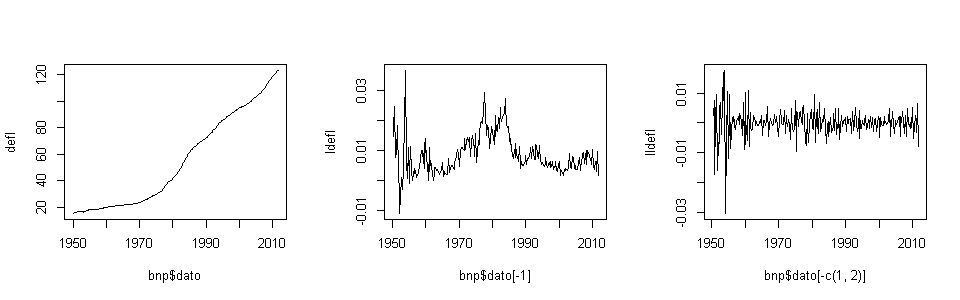

In [9]:
defl <- bnp$bnpdef
ldefl <- diff(log(bnp$bnpdef))
lldefl <- diff(diff(log(bnp$bnpdef)))

par(mfrow=c(1,3))
plot(defl~bnp$dato, type="l")
plot(ldefl~bnp$dato[-1], type="l")
plot(lldefl~bnp$dato[-c(1,2)], type="l")

ADF test: $H_0:\gamma = 0$ Hvilket indikerer en unit root (random walk)

$$\Delta y_t = a_o + \gamma y_{t-1} + bt + \sum^k_{i=1}\beta_i \Delta_{t-i}+\varepsilon_t$$
Hvis man ikke kan afvise $H_0$ så tager man differensen indtil at man kan og at serien er stationær.

In [10]:
level <- adf.test(defl)
diff.1 <- adf.test(ldefl)
diff.2 <- adf.test(lldefl)
rbind(level,diff.1,diff.2)

Warning message in adf.test(lldefl):
"p-value smaller than printed p-value"

,statistic,parameter,alternative,p.value,method,data.name
level,-2.602175,6,stationary,0.3223401,Augmented Dickey-Fuller Test,defl
diff.1,-3.3433,6,stationary,0.06453896,Augmented Dickey-Fuller Test,ldefl
diff.2,-9.518362,6,stationary,0.01,Augmented Dickey-Fuller Test,lldefl


**Spørgsmål 1.10** Opbyg (dvs. identificér og estimér) en ARIMA model for prisdefatoren, herunder tjek validiteten af den estimerede model.

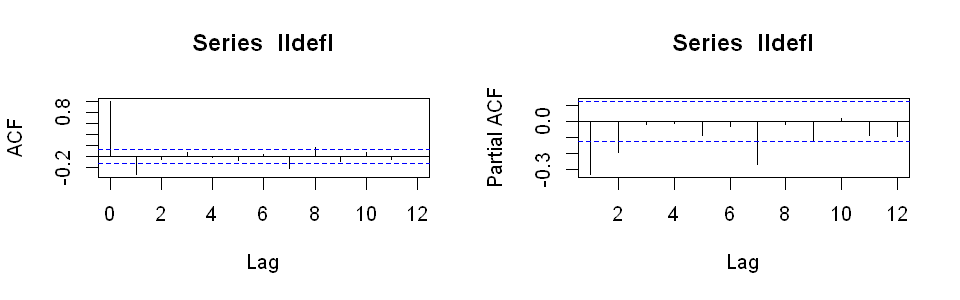

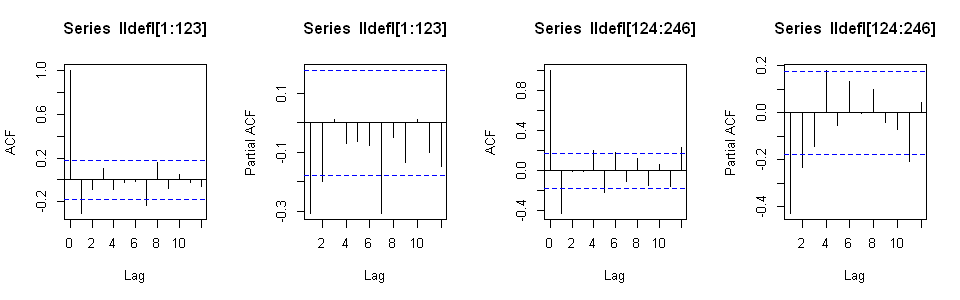

In [11]:
par(mfrow=c(1,2))
acf(lldefl, lag=12)
pacf(lldefl, lag=12)
par(mfrow=c(1,4))
acf(lldefl[1:123], lag=12)
pacf(lldefl[1:123], lag=12)
acf(lldefl[124:246], lag=12)
pacf(lldefl[124:246], lag=12)

In [12]:
AIC(arima(lldefl, order=c(0,2,1)))
AIC(arima(lldefl, order=c(1,2,0)))

BIC(arima(lldefl, order=c(0,2,1)))
BIC(arima(lldefl, order=c(1,2,0)))

[1] -1678.583

[1] -1569.77

[1] -1671.588

[1] -1562.775

Baseret på dette vælger jeg en AR(1) model som giver den numerisk laveste AIC samt BIC(SBC). Dette er modsat auto.arima, men denne anvender andre og mere komplicerede parametre.

<br>
<br>
<br>
<br>
<br>
<br>

---

## Opgave 2: Kointegration og fejlkorrektion [20%]
Vi betragter en månedlig 1-års renteserie $y_t$ og en månedlig 3-års renteserie $z_t$ fra juli 1956 til juni 2007 givet i datafilen “renter.csv”.

In [13]:
head(rnt,3)
rnt <- arrange(rnt, rnt$dato)

y,z,dato
1.79,2.23,1956-01-01
1.67,2.20,1956-02-01
1.66,2.07,1956-03-01


**Spørgsmål 2.1** 
*Undersøg både grafsk og vha. unit root tests om de to renteserier er stationære. Find for både $y_t$ og $z_t$ integrationsordenen d, svarende til at vi kan bruge betegnelsen “integreret af orden d”, I(d). Identificér og estimér en passende ARIMA for hver af tidsrækkerne $y_t$ og $z_t$.*

Vi finder at de begge er integreret af I(1). Dette kan både ses grafisk samt af Augmented Dickey Fuller testen. Når vi betragter Box Jenkins plottet ses det at der er en del autokorrelation som der skal tages højde for, vi anvender derfor en ARIMA(3,1,3) model på begge serier.

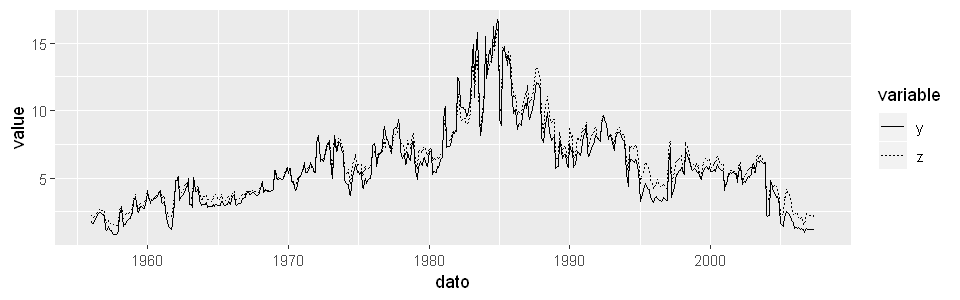

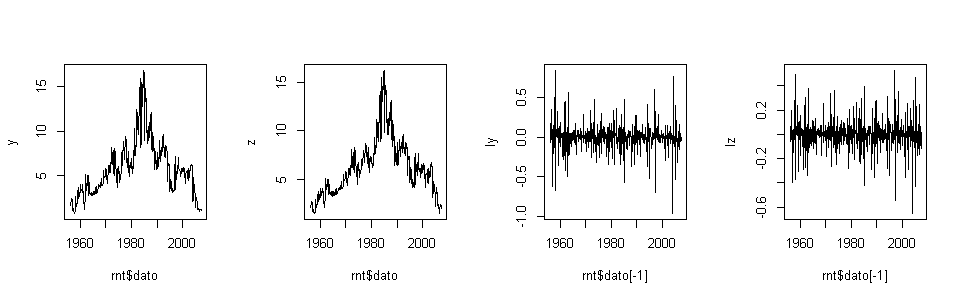

In [14]:
y <- rnt$y
z <- rnt$z
ly <- diff(log(rnt$y))
lz <- diff(log(rnt$z))
combi <- y - z

print(ggplot(gather(rnt, variable, value, -dato), aes(dato, value, linetype=variable)) + 
  geom_line())

par(mfrow=c(1,4))
plot(y~rnt$dato, type="l")
plot(z~rnt$dato, type="l")
plot(ly~rnt$dato[-1], type="l")
plot(lz~rnt$dato[-1], type="l")

In [15]:
adf.y <- adf.test(y)
adf.z <- adf.test(z)
adf.ly <- adf.test(ly)
adf.lz <- adf.test(lz)
adf.combi <- adf.test(combi)
rbind(adf.y, adf.z, adf.ly, adf.lz, adf.combi)

Warning message in adf.test(ly):
"p-value smaller than printed p-value"Warning message in adf.test(lz):
"p-value smaller than printed p-value"

,statistic,parameter,alternative,p.value,method,data.name
adf.y,-1.272287,8,stationary,0.8863383,Augmented Dickey-Fuller Test,y
adf.z,-0.9123566,8,stationary,0.9515763,Augmented Dickey-Fuller Test,z
adf.ly,-12.99691,8,stationary,0.01,Augmented Dickey-Fuller Test,ly
adf.lz,-12.97372,8,stationary,0.01,Augmented Dickey-Fuller Test,lz
adf.combi,-3.630971,8,stationary,0.02971241,Augmented Dickey-Fuller Test,combi


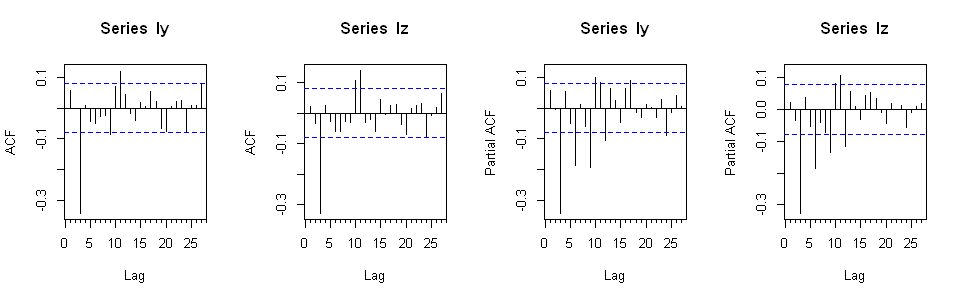

In [16]:
par(mfrow=c(1,4))
Acf(ly)
Acf(lz)
Pacf(ly)
Pacf(lz)

In [17]:
arima(y, order=c(3,1,3))
arima(z, order=c(3,1,3))


Call:
arima(x = y, order = c(3, 1, 3))

Coefficients:
          ar1      ar2     ar3     ma1     ma2      ma3
      -0.0376  -0.2245  0.2665  0.0879  0.1281  -0.7260
s.e.   0.0730   0.0847  0.0758  0.0563  0.0650   0.0476

sigma^2 estimated as 0.5545:  log likelihood = -687.6,  aic = 1389.21


Call:
arima(x = z, order = c(3, 1, 3))

Coefficients:
          ar1      ar2     ar3     ma1     ma2      ma3
      -0.0904  -0.1674  0.1744  0.0986  0.1033  -0.6779
s.e.   0.0667   0.0678  0.0635  0.0490  0.0510   0.0450

sigma^2 estimated as 0.4104:  log likelihood = -595.54,  aic = 1205.07

**Spørgsmål 2.2** 
*Kointegrerer de to tidsrækker?*

Vi finder at de med en Johansen trace test at vi klart kan afvise at rangen er 0 (som betyder at ???)
Vi kan dog ikke afvise på et 1% signifikansniveau at rangen er 1 eller mindre.. så vi konkluderer at rangen er 1. Dette betyder at ???. Dette bekræftes også at en linær kombination $y_t - z_t$ er stationær som kan ses i de ovenstående ADF test.

Vi kan også se dette ved at regressere y på z og kontrollere om residualerne er stationære, dette gør jeg ved en Augmented Dickey Fuller test og denne viser at vi på et 5% signigikansniveau kan afvise at residualerne ikke er stationære

In [18]:
jo <- ca.jo(data.frame(y,z), type="trace", K=2, ecdet="none", spec="longrun")
summary(jo)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.07443070 0.01532624

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  9.42  6.50  8.18 11.65
r = 0  | 56.60 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

          y.l2      z.l2
y.l2  1.000000  1.000000
z.l2 -1.001242 -2.002885

Weights W:
(This is the loading matrix)

           y.l2       z.l2
y.d -0.19361099 0.03353670
z.d -0.05045118 0.03178485


In [58]:
reg <- lm(y ~ z)
adf.test(reg$residuals)


	Augmented Dickey-Fuller Test

data:  reg$residuals
Dickey-Fuller = -3.6317, Lag order = 8, p-value = 0.02964
alternative hypothesis: stationary


**Spørgsmål 2.3** 
Hvis tidsrækkerne kointegrerer opbyg da og estimér en fejlkorrektions- model for tidsrækkerne, og opskriv således den estimerede model.

Vi begynder med en simpel VAR(1) model
$$y_t = a_{11}y_{t-1} + a_{12}z_{t-1} + \varepsilon_{yt}$$
$$z_t = a_{21}y_{t-1} + a_{22}z_{t-1} + \varepsilon_{zt}$$

omskrives til:

$$
\begin{bmatrix} \Delta y_t \\ \Delta z_t \end{bmatrix}
=
\underbrace{
\begin{bmatrix} a_{11}-1 & a_{12} \\ a_{21} & a_{22}-1 \end{bmatrix}
}_{\pi}
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} \varepsilon_{yt} \\ \varepsilon_{zt} \end{bmatrix}
$$

Dette kan igen omskrives til føgende fejlkorrentionsmodel 

$$\Delta y_t = -[a_{12}a_{21}/(1-a_{22})]y_{t-1} + a_{12}z_{t-1} + \varepsilon_{yt}$$
$$\Delta z_t = a_{21}y_{t-1}-(1-a_{22})z_{t-1} + \varepsilon_{zt}$$

som kan omskrives til en VECM(0):

$$\Delta y_t = \alpha_y(y_{t-1}-\beta z_{t-1}) + \varepsilon_{yt}$$
$$\Delta z_t = \alpha_z(y_{t-1}-\beta z_{t-1}) + \varepsilon_{zt}$$
og disse variabler er givet ved

$$\alpha_y = -a_{12}a_{21}/(1-a_{22})$$
$$\beta = (1-a_{22})/a_{21}$$
$$\alpha_z = a_{21}$$






Hvis vi anvender informationerne i summary i sidste opgave er parametrene i VECM(0) modellen:
$$\alpha_y = -0.19361099 $$
$$\beta = -1.001242 $$
$$\alpha_z = -0.05045118 $$


In [19]:
VAR(data.frame(y,z), p=1, type="none")


VAR Estimation Results:

Estimated coefficients for equation y: 
Call:
y = y.l1 + z.l1 

     y.l1      z.l1 
0.8241100 0.1607344 


Estimated coefficients for equation z: 
Call:
z = y.l1 + z.l1 

       y.l1        z.l1 
-0.06195626  1.05333779 



In [20]:
(1-1.05333779)/-0.06195626

[1] 0.8608943

In [21]:
-0.1607344*-0.06195626/(1-1.05333779 )

[1] -0.1867063

In [22]:
-0.06195626

[1] -0.06195626

<br>
<br>
<br>
<br>
<br>
<br>

---

## Opgave 3: Volalitetsmodeller [25%]
Betegn aktiekursen på tid $t$ for en given virksomhed ved $Y_t$: Afkastet beregner vi her ved $y_t = \Delta log Y_t = log Y_t - log Y_{t-1}$ hvor log som standard angiver den naturlige logaritme.

In [23]:
head(vol)
aktie <- vol$aktiekurs
afkast <- diff(log(aktie))

dato,aktiekurs
2001-01-02,1662.646
2001-01-03,1980.806
2001-01-04,1893.569
2001-01-05,1739.620
2001-01-08,1785.804
2001-01-09,1698.567


**Spørgsmål 3.1** *Beskriv nogle af de væsentligste forskelle mellem at modellere $y_t$ som en AR(1) process og yt som en GARCH(1,1) process. Skriv begge modeller op, forklar alle symboler i de 2 modelspecifikationer og husk at påpege hvor vi formelt ser forskellene mellem de 2 modeller.*

AR(1)
$$ y_t = \alpha + \beta y_{t-1} + \varepsilon_t $$


GARCH(1,1)

$$ \varepsilon_t = v_t \sqrt{h_t}$$
$$ h_t = \alpha_0 + \alpha_1\varepsilon^2_{t-1} + \beta h_{t-1}$$

En vigtig forskel på de to modeller er at ved AR (ARIMA) er $E_t[\cdot]$ , altså den betingede værdi, varierende med tiden, mens den er konstant for en GARCH (ARCH) model, modsat er $var_t[\cdot]$, altså den betingede varians, varierende over tid i en GARCH, mens den ikke er for en AR.

Det er dog muligt både at modelere middelværdien samt variansen i en serie, altså en ARIMA med GARCH fejlled

**Spørgsmål 3.2** *Forklart kort hvordan du indledningsvist kan forsøge grafisk at afsløre ARCH/GARCH effekter i $y_t$:*

Man kan regressere serien på en konstant, så plotter du det kvardrerede residual, hvis dette ikke er nogenlunde konstant er der tegn på ARCH/GARCH fejl.

**Spørgsmål 3.3** Hvordan kan du indledningsvist forsøge at afsløre ARCH/GARCH effekter i $y_t$ ved et formelt test? Skriv nul-hypotesen op.

**Spørgsmål 3.4** Du bedes nu estimere en AR(5) - GARCH (1,1) for data i datafilen "volatilitet.csv"og hvor du besvarer følgende underpunkter
 - Forklar om du vil estimere modellen på baggrund af $Y_t$ eller $y_t$ og argumenter hvorfor.
 - Lav et indledende grafisk og formelt test for ARCH/GARCH effekter.
 - Rapportér og kommentér ganske kort på parameterestimater og tilhørende standard errors samt informationskriterie(r).

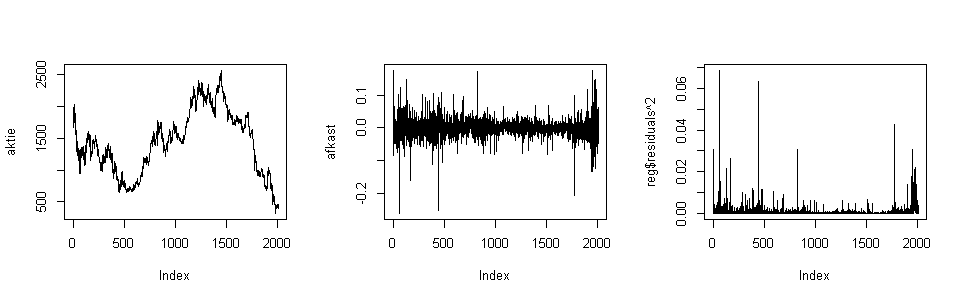

In [24]:
par(mfrow=c(1,3))
plot(aktie, type="l")
plot(afkast, type="l")

reg <- lm(afkast~1)
plot(reg$residuals^2, type="l")

Jeg anvender den logdifferencierede $y_t$, plot nr. 2, eftersom den er stationær

In [25]:
spec <- ugarchspec(variance.model = list(model = "sGARCH", 
                                         garchOrder = c(1, 1),
                                         variance.targeting = FALSE), 
                   mean.model     = list(armaOrder = c(5, 0), 
                                         external.regressors = NULL))

m2 <- ugarchfit(spec = spec, data = afkast)
m2


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(5,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000297    0.000481   0.61794 0.536615
ar1     0.033367    0.024899   1.34005 0.180228
ar2    -0.031395    0.024529  -1.27992 0.200571
ar3     0.008874    0.024465   0.36273 0.716808
ar4    -0.034016    0.024271  -1.40153 0.161054
ar5    -0.039536    0.023960  -1.65006 0.098930
omega   0.000012    0.000004   2.93730 0.003311
alpha1  0.080992    0.010498   7.71478 0.000000
beta1   0.909625    0.005712 159.25274 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000297    0.000590  0.50390 0.614332
ar1     0.033367    0.025625  1.30212 0.192876
ar2    -0.031395    0.027387 -1.14635 0.25165

**Spørgsmål 3.5** Forsøg at forbedre ovenstående AR(5) - GARCH (1,1) model ved at estimere en AR (p) - GARCH (1,1) med p < 5, en ARMA(1,1) - GARCH (1,1) samt en valgfri model. Med ovenstående model ender du således med ialt 4 modeller.
 - Lav en tabel med AIC eller SIC/BIC for de 4 modeller. Hvilken model vil du vælge? Kommentér kort på parametersignifikans for valgte model.

In [26]:
m1 <- ugarchfit(spec = ugarchspec(variance.model = list(model = "sGARCH", 
                                                        garchOrder = c(1, 1)),
                                  mean.model     = list(armaOrder = c(5, 0))), 
                data = afkast)

m2 <- ugarchfit(spec = ugarchspec(variance.model = list(model = "sGARCH", 
                                                        garchOrder = c(1, 1)),
                                  mean.model     = list(armaOrder = c(3, 0))), 
                data = afkast)

m3 <- ugarchfit(spec = ugarchspec(variance.model = list(model = "sGARCH", 
                                                        garchOrder = c(1, 1)),
                                  mean.model     = list(armaOrder = c(1, 1))), 
                data = afkast)

m4 <- ugarchfit(spec = ugarchspec(variance.model = list(model = "sGARCH", 
                                                        garchOrder = c(1, 1)),
                                  mean.model     = list(armaOrder = c(4, 4))), 
                data = afkast)

In [27]:
a1 <- infocriteria(m1)
a2 <- infocriteria(m2)
a3 <- infocriteria(m3)
a4 <- infocriteria(m4)
df <- cbind(a1,a2,a3,a4)
colnames(df)<- c("model 1", "model 2", "model 3", "model 4")
round(df,3)


,model 1,model 2,model 3,model 4
Akaike,-4.408,-4.407,-4.409,-4.410
Bayes,-4.383,-4.388,-4.393,-4.377
Shibata,-4.408,-4.407,-4.409,-4.410
Hannan-Quinn,-4.398,-4.400,-4.403,-4.398


**Spørgsmål 3.6** Lav en diagnose afvalgte model ved brug afpassende tests og kommentér kort.

**Spørgsmål 3.7** For den valgte model bedes du lave et volatilitetsforecast for tidspunkt T + h; hvor h betegner forecast horisonten og T er sluttidspunktet i din stikprøve. Lad h = 1: Du bruger således hele din stikprøve til at estimere parametrene som efterfølgende bruges til at lave et forecast "uden for stikprøven"på tid T + 1. Beregn også et ubetinget volatilitetsforecast.

$$ var(\epsilon_t) = E(\epsilon_t) = \frac{\alpha_0}{1-\sum^P_{i=1}\alpha_i - \sum^Q_{i=1}\beta_i} $$

$$omega = 0.000012$$
$$alpha1 = 0.080992$$
$$beta1 = 0.909625$$

In [28]:
length(afkast)

[1] 2010

In [29]:
forc <- ugarchforecast(m2, n.ahead = 1, data = afkast)

forc@forecast$sigmaFor[1]

sqrt(0.000012/(1-0.080992-0.909625))


[1] 0.04488681

[1] 0.03576183

<br>
<br>
<br>
<br>
<br>
<br>

---

## Opgave 4: Vektorautoregressive modeller [25%]
I datafilen "VektorAutoregressiv.csv" finder du 3 tidsrækker for nominelle oliepris (NO), reale BNP (RBNP) og et forbrugerprisindeks (P). Alle tidsrækker er i niveau.

In [30]:
head(var,3)

Dato,NominelOliePris,RealBNP,PrisIndeks
1975-03-31,11.16,5292.4,52.567
1975-06-30,11.16,5333.2,53.200
1975-09-30,11.16,5421.4,54.267


**Spørgsmål 4.1** Transformér tidsrækkerne til log differencer $(\Delta log)$: Den reale vækstrate for BNP (rbnp) bliver således $rbnpt = \Delta log (RBNPt)$: For olieprisen (NO) bereg- ner du endvidere den reale vækstrate (ro) ved $ro_t = no_t - \pi_t$, hvor $no_t = \Delta log(NO_t)$ og hvor forbrugerprisvæksten beregnes som $\pi_t = \Delta log(P_t)$ Forklar med egne ord hvorfor vi kan opfatte $ro_t$ som en real vækstrate? Er der tale om en årlig vækstrate?

date,pi,rbnp,ro
1975-06-30,0.01196985,0.007679604,-0.01196985
1975-09-30,0.01985791,0.016402651,-0.01985791
1975-12-31,0.01825968,0.013375307,-0.01825968


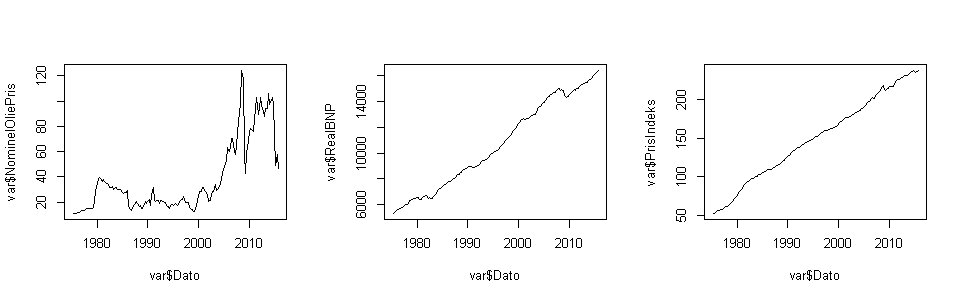

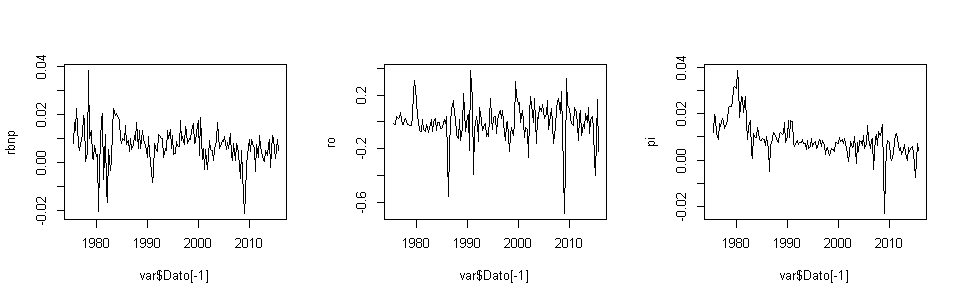

In [52]:
rbnp <- diff(log(var$RealBNP))
ro <- diff(log(var$NominelOliePris)) - diff(log(var$PrisIndeks))
pi <- diff(log(var$PrisIndeks))
df <- data.frame(date = var$Dato[-1], pi, rbnp,ro)
head(df,3)

par(mfrow=c(1,3))
plot(var$NominelOliePris~var$Dato, type="l")
plot(var$RealBNP~var$Dato, type="l")
plot(var$PrisIndeks~var$Dato, type="l")

plot(rbnp~var$Dato[-1], type="l")
plot(ro~var$Dato[-1], type="l")
plot(pi~var$Dato[-1], type="l")

**Spørgsmål 4.2** Tag udgangspunkt i en stikprøve for for rbnp og for perioden andet kvartal 1976 til og med tredje kvartal 2010. Brug denne variableorden. Estimér en VAR med en laglængde på p = 2: Hvad er et statistisk argument for, at repræsentere denne VAR i vækstrater?

In [59]:
sub <- subset(df, date > "1976-01-02" & date < "2010-08-02")

m <-VAR(sub[,-1], p=2, type="const")
m


VAR Estimation Results:

Estimated coefficients for equation pi: 
Call:
pi = pi.l1 + rbnp.l1 + ro.l1 + pi.l2 + rbnp.l2 + ro.l2 + const 

       pi.l1      rbnp.l1        ro.l1        pi.l2      rbnp.l2        ro.l2 
 0.447851509  0.104297528  0.008330835  0.383727724 -0.052615763 -0.013379882 
       const 
 0.001251070 


Estimated coefficients for equation rbnp: 
Call:
rbnp = pi.l1 + rbnp.l1 + ro.l1 + pi.l2 + rbnp.l2 + ro.l2 + const 

       pi.l1      rbnp.l1        ro.l1        pi.l2      rbnp.l2        ro.l2 
-0.090396639  0.326953563 -0.001136950 -0.118915802  0.109543024  0.002494476 
       const 
 0.006052028 


Estimated coefficients for equation ro: 
Call:
ro = pi.l1 + rbnp.l1 + ro.l1 + pi.l2 + rbnp.l2 + ro.l2 + const 

        pi.l1       rbnp.l1         ro.l1         pi.l2       rbnp.l2 
-0.9017900724  1.6570456476  0.3125915486  0.5068360506 -0.6562776784 
        ro.l2         const 
-0.2505746561  0.0004642684 



**Spørgsmål 4.3** Er den pågældende VAR stationær?

**Spørgsmål 4.4** Du skal nu lave en impulse respons analyse, men inden da bedes du redegøre for om denne VAR er velspecificeret i form af antallet af lags. Hvor mange lags vil du argumentere for? Inkludér kun det væsentligste program output i din besvarelse.

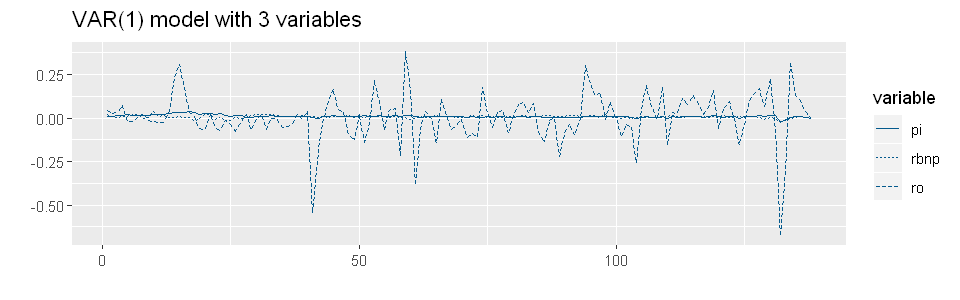

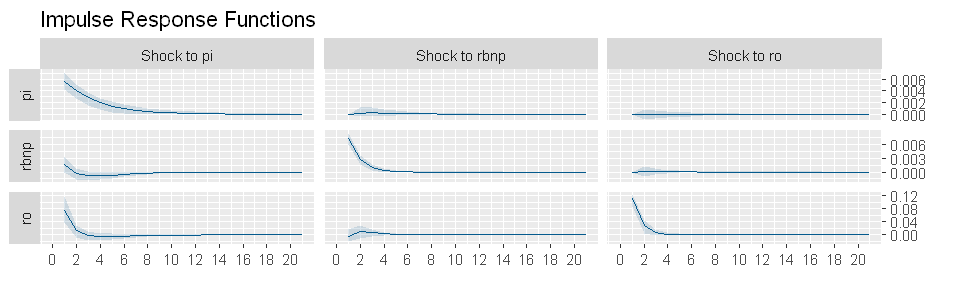

In [68]:
irf_lars(sub[,-1])

**Spørgsmål 4.5** Skriv en central formel op for impulse respons analysen og forklar formlen og alle symboler.

**Spørgsmål 4.6** *På baggrund af valgte antal lags ovenfor, bedes du nu foretage en ortogonaliseret impulse respons analyse. Med ortogonaliseret menes en analyse på baggrund af en Cholesky dekomponering. I appendiks kan du rapportere alle responsene til hver af de 3 choks, mens du i hovedteksten grfisk viser responses for variablene $\{\pi,rbnp,ro\}$ som følger af en chok til den reale oliepris. Endvidere opstiller du i hovedteksten en $10 \times 3$ tabel hvor du viser responsen de første 10 perioder for hver af variablene til samme chok. Over maksimalt 0.5 side kommenterer du på impulse respons resultaterne - hvad viser de og er resultaterne plausible?*

Her ses konsekvensen af et oliechok, det ses at denne er taget som den mest eksogene af variablerne og der derfor ikke er nogen simultan påvirkning fra et olieprischok til det reale bnp eller inflationen

In [67]:
irf(m)$irf$ro

pi,rbnp,ro
0.0000000000,0.000000e+00,0.1091754420
0.0009095226,-1.241270e-04,0.0341273205
-0.0007820604,1.107329e-04,-0.0177145694
-0.0005873544,9.041663e-05,-0.0126576819
-0.0004279721,1.579888e-04,0.0006925846
-0.0002302035,1.377308e-04,0.0036788953
-0.0002398879,1.315853e-04,0.0010916726
-0.0002294210,1.151054e-04,-0.0003532839
-0.0002072661,1.044385e-04,-0.0001942949
-0.0001729151,9.211313e-05,0.0001959390


**Spørgsmål 4.7** *I analysen antog vi en bestemt orden af variablene i VAR analysen; specifikt $\{\pi,rbnp,ro\}$ : Argumentér for denne orden men giv også med baggrund i Cholesky dekomponeringen en kritik afimpulse respons analysen. Har du forslag til forbedringer?*

Udfordringen når der medtages strukturelle parmetre er at modellen bliver underidenticeret. Dette løses ved Cholesky dekomponeringen ved at tage nogle simultane stød som eksogene, og bygge ud fra det. Derfor bliver parametrene ordnet efter deres niveau af simultant eksogenitet (de er alle endogene eftersom deres lags indgår i modellen). 

**Spørgsmål 4.8** Redegør kort for om resultaterne, som følge af choks til den reale oliepris, vil ændres hvis du betragter denne orden $\{rbnp,\pi,ro\}$

In [34]:
irf_lars <- function(x) {
    m <- VAR(x, p = 1, type = "const")
    hej <- ncol(x)
    chart_title <- substitute(paste("VAR(1) model with ", hej," variables"))
psim <- as.data.frame(x)
psim$n <- c(1:138)
psim <- gather(psim, variable, value, -n)

p1 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line(color="#045a8d") + 
 labs(title=chart_title, x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows

p2 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line(color="#045a8d") +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.15, fill="#045a8d") +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,2)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, scales="free", switch="y")

print(p1); print(p2)
}